In [1]:
import sys
import logging
import pickle
import yaml
import matplotlib.cm as cm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import pandas as pd
from scipy.stats import sem
from configs import engram_dir

# Parameters

In [2]:
generic_exp_name = 'new_gridworld8x8_shuffobs'
network_yaml = 'dm'
episode = 600
models = ['mf0', 'entro0', 'g0_-2_entro-1']
model_labels = ['MF', 'MF + N', 'MF + P/N']

In [3]:
dims = np.arange(2,20)

In [4]:
episode = 600

In [5]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    vals[n:-n] = smoothed[n:-n]
    return vals

# Collecting info

In [6]:
data = {
    'dims': [],
    'zerofields': [],
    'models': []
}

for internal_dim in dims:
    exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
    analysis_dir = f'{engram_dir}analysis/{exp_name}/'
    repr_df_path = f'{analysis_dir}representation_df_ep{episode}.p'
    if not os.path.exists(repr_df_path):
        continue
    with open(repr_df_path, 'rb') as f:
        repr_df = pickle.load(f)
    for model in models:
        _model = f'{generic_exp_name}_{model}'
        model_df = repr_df[repr_df['model'] == _model]
        if model_df.empty:
            continue
        iterations = np.unique(model_df['iteration'])
        for i in iterations:
            _df = model_df[model_df['iteration'] == i]
            width = np.max(_df['x']) + 2
            height = np.max(_df['y']) + 2
            _sample = np.array(_df.head(1)['latents'].item())
            n_units = _sample.size
            heatmap = np.zeros((n_units, width, height))
            for _, row in _df.iterrows():
                x = row['x']
                y = row['y']
                latents = np.array(row['latents'])
                heatmap[:,x,y] = latents
            heatmap[heatmap<0] = 0
            hh = np.sum(heatmap.reshape((internal_dim,-1)), axis=1)
            data['dims'].append(internal_dim)
            data['zerofields'].append(np.sum(hh < 1E-4)/internal_dim)
            data['models'].append(model)

# Measuring collapse

In [7]:
df = pd.DataFrame(data)

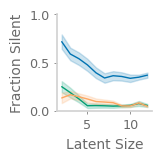

In [17]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0])]
smooth_line = True
fig, ax = plt.subplots(
    figsize=(1.5, 1.5), constrained_layout=True)
dims = np.unique(df['dims'])
dims.sort()
for _idx, model in enumerate(models):
    means = []
    sems = []
    for d in dims:
        r = df[(df['models']==model) & (df['dims']==d)]
        zerofields = r['zerofields']
        means.append(np.mean(zerofields))
        sems.append(sem(zerofields))
    means = np.array(means)
    sems = np.array(sems)
    means = smooth(dims, means, 2)
    sems = smooth(dims, np.array(sems), 2)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    ax.plot(dims, means, label=model, color=colors[_idx])
    ax.fill_between(
        dims, mean_lowerbound,
        mean_upperbound, alpha=0.2, color=colors[_idx])
plt.ylabel('Fraction Silent')
plt.xlabel('Latent Size')
plt.ylim(0, 1.0)
plt.savefig('1f.png', dpi=300, transparent=True)
plt.show()